# W symmetry, z_co shapes and meaning
This is a notebook to remind myself why I do the calculations in the way that I am doing them. It should cover the following series of points:
* Why w is the way that it is, why is it the first element in the dot product np.dot(w, o)
* In the dynamic equations how the z_co and p_co are build, and why it makes sense in the light of the role of w.
* An example illustrating that this works properly

We start by loading the libraries as usual

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from network import BCPNN, NetworkManager
from data_transformer import build_ortogonal_patterns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

#### Git 
Here we have the git machinery to run this in the original version when it was build

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '78d59994a229080583cdcff5bfff3c28caf385ef'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

## How the dot product works

In [3]:
w = np.arange(9).reshape((3, 3))
x = np.ones(3)
result1 = np.dot(w, x)
result2 = np.dot(x, w)
print('w')
pprint.pprint(w)
print('x')
pprint.pprint(x)
print('dot(w, x)')
pprint.pprint(result1)
print('dot(x, w)')
pprint.pprint(result2)

w
array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])
x
array([ 1.,  1.,  1.])
dot(w, x)
array([  3.,  12.,  21.])
dot(x, w)
array([  9.,  12.,  15.])


We want the result that sums the multiplications over the rows and therefore we chose np.dot(w, o). 

**In this contex $w_{ij}$ represents the influence of $o_j$ in $o_i$ and that how is should be read**

## How the coactivations work (Outer product)
In our calculations $w_{ij}$ depend on $zco_{ij}$ which is calculate with an outer product. Here we calculate how the dot product depends in the order and justify our choice

In [4]:
x = np.arange(3)
y = np.ones(3)
result1 = np.outer(x, y)
result2 = np.outer(y, x)
print('x')
pprint.pprint(x)
print('y')
pprint.pprint(y)
print('outer(x, y)')
pprint.pprint(result1)
print('outer(y, x)')
pprint.pprint(result2)

x
array([0, 1, 2])
y
array([ 1.,  1.,  1.])
outer(x, y)
array([[ 0.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 2.,  2.,  2.]])
outer(y, x)
array([[ 0.,  1.,  2.],
       [ 0.,  1.,  2.],
       [ 0.,  1.,  2.]])


If $r$ is the result, we can see that $r_{ij}= x_i y_j$ for the first result and that $r_{ij}= y_i x_j $ for the second result.

## Running example

First we build the patterns and the network

In [5]:
hypercolumns = 2
minicolumns = 10
n_patterns = 10  # Number of patterns

patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

# Build the network
tau_z_pre = 0.500
tau_z_post = 0.050

nn = BCPNN(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre)

Then we build the network manager

In [6]:
dt = 0.001
T_training = 1.0
time_training = np.arange(0, T_training, dt)
T_ground = 1.0
time_ground = np.arange(0, T_ground, dt)
values_to_save = ['o', 'z_pre', 'z_post', 'p_pre', 'p_post', 'p_co', 'z_co', 'w']

manager = NetworkManager(nn=nn, values_to_save=values_to_save)

Finally we trained the network and extract the history

In [7]:
repetitions = 3
resting_state = False

for i in range(repetitions):
    print('repetitions', i)
    for pattern in patterns:
        nn.k = 1.0
        manager.run_network(time=time_training, I=pattern)
        nn.k = 0.0
        if resting_state:
            manager.run_network(time=time_ground)

history = manager.history

if resting_state:
    T_total = n_patterns * repetitions * (T_training + T_ground)
else:
    T_total = n_patterns * repetitions * T_training

total_time = np.arange(0, T_total, dt)

repetitions 0
repetitions 1
repetitions 2


Extract the quantities to plot

In [8]:
z_pre_hypercolum = history['z_pre'][..., :minicolumns]
z_post_hypercolum = history['z_post'][..., :minicolumns]
o_hypercolum = history['o'][..., :minicolumns]
p_pre_hypercolum = history['p_pre'][..., :minicolumns]
p_post_hypercolum = history['p_post'][..., :minicolumns]

p_co = history['p_co']
z_co = history['z_co']
w = history['w']

p_co01 = p_co[:, 0, 1]
p_co10 = p_co[:, 1, 0]

z_co01 = z_co[:, 0, 1]
z_co10 = z_co[:, 1, 0]

w01 = w[:, 0, 1]
w10 = w[:, 1, 0]

aux01 = p_co01 / (p_pre_hypercolum[:, 0] * p_post_hypercolum[:, 1])
aux10 = p_co10 / (p_pre_hypercolum[:, 1] * p_post_hypercolum[:, 0])


/home/heberto/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in divide
/home/heberto/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide


#### Plotting

In [9]:
import seaborn as sns
sns.set_context('notebook', font_scale=2.0)

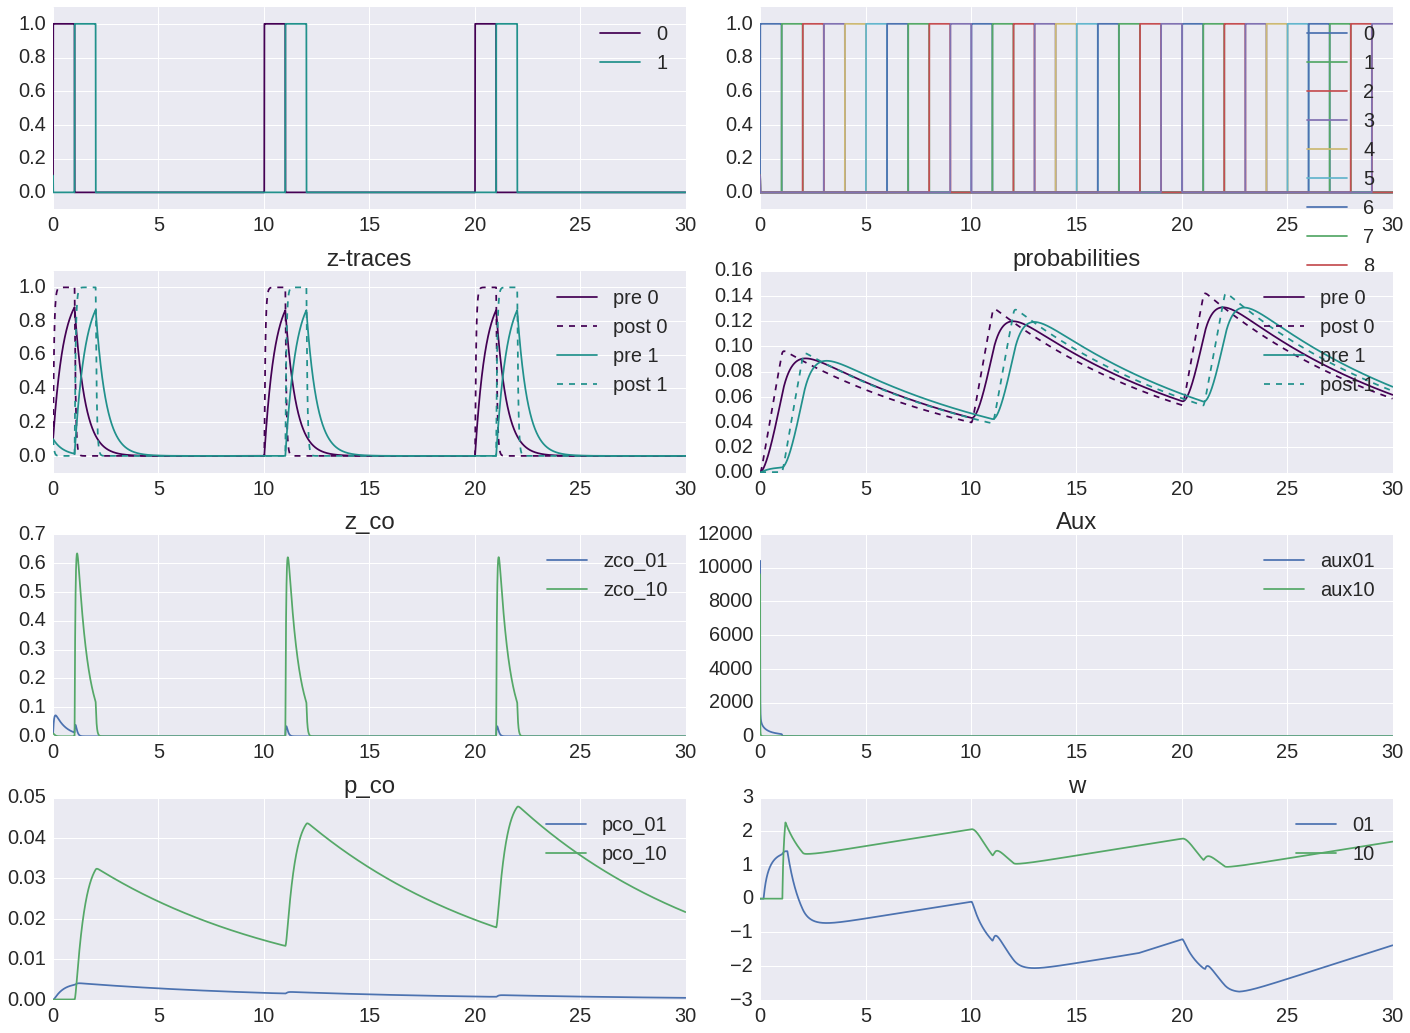

In [10]:
cmap = matplotlib.cm.get_cmap('viridis')
traces_to_plot = [0, 1]
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(traces_to_plot))

# Plot the traces
fig = plt.figure(figsize=(20, 15))
ax11 = fig.add_subplot(421)
ax12 = fig.add_subplot(422)
ax21 = fig.add_subplot(423)
ax22 = fig.add_subplot(424)
ax31 = fig.add_subplot(425)
ax32 = fig.add_subplot(426)
ax41 = fig.add_subplot(427)
ax42 = fig.add_subplot(428)

fig.tight_layout()
# fig.subplots_adjust(right=0.8)

for index in range(minicolumns):
    # Plot ALL the activities
    ax12.plot(total_time, o_hypercolum[:, index], label=str(index))


for index in traces_to_plot:
    # Plot activities
    ax11.plot(total_time, o_hypercolum[:, index], color=cmap(norm(index)), label=str(index))
    # Plot the z post and pre traces in the same graph
    ax21.plot(total_time, z_pre_hypercolum[:, index], color=cmap(norm(index)), label='pre ' + str(index))
    ax21.plot(total_time, z_post_hypercolum[:, index], color=cmap(norm(index)), linestyle='--', label='post ' + str(index))

    # Plot the pre and post probabilties in the same graph
    ax22.plot(total_time, p_pre_hypercolum[:, index], color=cmap(norm(index)), label='pre ' + str(index))
    ax22.plot(total_time, p_post_hypercolum[:, index], color=cmap(norm(index)), linestyle='--', label='post ' + str(index))

# Plot z_co and p_co in the same graph
ax31.plot(total_time, z_co01, label='zco_01')
ax31.plot(total_time, z_co10, label='zco_10')

# Plot the aux quantity
ax32.plot(total_time, aux01, label='aux01')
ax32.plot(total_time, aux10, label='aux10')

# Plot the coactivations probabilities
ax41.plot(total_time, p_co01, '-', label='pco_01')
ax41.plot(total_time, p_co10, '-',label='pco_10')

# Plot the weights
ax42.plot(total_time, w01, label='01')
ax42.plot(total_time, w10, label='10')

axes = fig.get_axes()
for ax in axes:
    ax.set_xlim([0, T_total])
    ax.legend()

ax11.set_ylim([-0.1, 1.1])
ax12.set_ylim([-0.1, 1.1])
ax21.set_ylim([-0.1, 1.1])

ax21.set_title('z-traces')
ax22.set_title('probabilities')
ax31.set_title('z_co')
ax32.set_title('Aux')
ax41.set_title('p_co')
ax42.set_title('w')

plt.show()

We observe that every time that there is activity of 1 preceded by 0 the zco_10 rises which is exactly that we expected. 

Why?
w10 is a measure of the effect of 0 and 1. And is proportional to z10. 

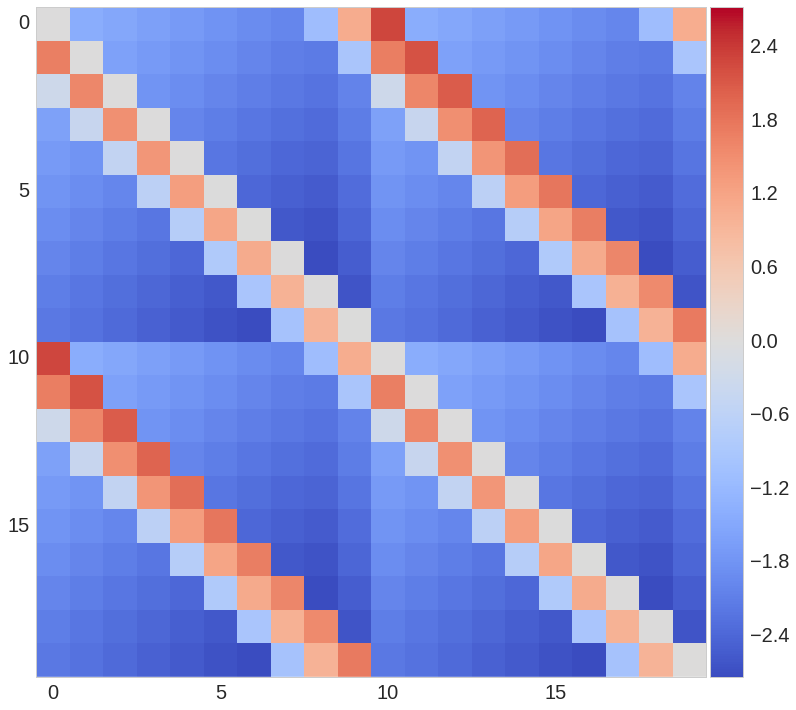

In [11]:
sns.set_style("whitegrid", {'axes.grid' : False})
w = nn.w
aux_max = np.max(np.abs(w))

cmap = 'coolwarm'
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(111)
im1 = ax1.imshow(w, cmap=cmap, interpolation='None', vmin=-aux_max, vmax=aux_max)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, ax=ax1, cax=cax1)

#### Git reset

In [12]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])